In [1]:
from wmi_backend_2 import *
from wmi_decompositions import *

import numpy as np

from qiskit import *
from qiskit.circuit.library import XXPlusYYGate
from qiskit.transpiler import Layout
from qiskit.quantum_info.operators import Operator

from qiskit.visualization import *
from util import *

### Reference Hamiltonian

In [2]:
u = 1
t = 1
delta_t = 1

In [3]:
lattice_size = (2,2)
Nx, Ny = lattice_size
num_sites = Nx*Ny

In [4]:
from qiskit.opflow import X, Y, Z, I, PauliTrotterEvolution, PauliSumOp
from qiskit.circuit import Parameter

# 1↑ 2↑ 3↑ 4↑ 1↓ 2↓ 3↓ 4↓


# interaction term
A = 1/2*(I-Z)
H1 = (A^I^I^I^A^I^I^I) + (I^A^I^I^I^A^I^I) + (I^I^A^I^I^I^A^I) + (I^I^I^A^I^I^I^A)

# hopping term
H2 = -2*t*(
            (X^I^X^I^I^I^I^I) + (Y^I^Y^I^I^I^I^I)
            +(I^X^I^X^I^I^I^I) + (I^Y^I^Y^I^I^I^I)
            +(I^I^I^I^X^X^I^I) + (I^I^I^I^Y^Y^I^I)
            +(I^I^I^I^I^I^X^X) + (I^I^I^I^I^I^Y^Y)

            +(X^X^I^I^Z^Z^I^I) + (Y^Y^I^I^Z^Z^I^I)
            +(I^I^X^X^I^I^Z^Z) + (I^I^Y^Y^I^I^Z^Z)
            +(Z^I^Z^I^X^I^X^I) + (Z^I^Z^I^Y^I^Y^I)
            +(I^Z^I^Z^I^X^I^X) + (I^Z^I^Z^I^Y^I^Y)
            )
hamiltonian = H1 + H2
# evolution operator
evo_time = Parameter('t')
evolution_op = (evo_time*hamiltonian).exp_i()
print(evolution_op)
# into circuit
num_time_slices = 1
trotterized_op = PauliTrotterEvolution(
                    trotter_mode='trotter',
                    reps=num_time_slices).convert(evolution_op)

e^(-i*t * (
  0.25 * IIIIIIII
  - 0.25 * IIIIZIII
  - 0.25 * ZIIIIIII
  + 0.25 * ZIIIZIII
  + 0.25 * IIIIIIII
  - 0.25 * IIIIIZII
  - 0.25 * IZIIIIII
  + 0.25 * IZIIIZII
  + 0.25 * IIIIIIII
  - 0.25 * IIIIIIZI
  - 0.25 * IIZIIIII
  + 0.25 * IIZIIIZI
  + 0.25 * IIIIIIII
  - 0.25 * IIIIIIIZ
  - 0.25 * IIIZIIII
  + 0.25 * IIIZIIIZ
  - 2.0 * XIXIIIII
  - 2.0 * YIYIIIII
  - 2.0 * IXIXIIII
  - 2.0 * IYIYIIII
  - 2.0 * IIIIXXII
  - 2.0 * IIIIYYII
  - 2.0 * IIIIIIXX
  - 2.0 * IIIIIIYY
  - 2.0 * XXIIZZII
  - 2.0 * YYIIZZII
  - 2.0 * IIXXIIZZ
  - 2.0 * IIYYIIZZ
  - 2.0 * ZIZIXIXI
  - 2.0 * ZIZIYIYI
  - 2.0 * IZIZIXIX
  - 2.0 * IZIZIYIY
))


C:\Users\thilo\AppData\Local\Temp\ipykernel_27036\684043398.py:1: DeprecationWarning: The ``qiskit.opflow`` module is deprecated as of qiskit-terra 0.24.0. It will be removed no earlier than 3 months after the release date. For code migration guidelines, visit https://qisk.it/opflow_migration.
  from qiskit.opflow import X, Y, Z, I, PauliTrotterEvolution, PauliSumOp
C:\Users\thilo\AppData\Local\Temp\ipykernel_27036\684043398.py:30: DeprecationWarning: The class ``qiskit.opflow.evolutions.pauli_trotter_evolution.PauliTrotterEvolution`` is deprecated as of qiskit-terra 0.24.0. It will be removed no earlier than 3 months after the release date. For code migration guidelines, visit https://qisk.it/opflow_migration.
  trotterized_op = PauliTrotterEvolution(


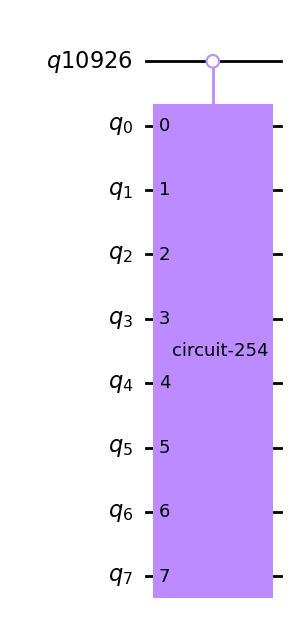

In [5]:
param_bind = {
    evo_time: 1,
}
qc_ref = trotterized_op.bind_parameters(param_bind).eval().to_circuit().control(ctrl_state="0")
ref_matrix = circuit2matrix(qc_ref, keep_qiskit_ordering=False)
qc_ref.draw("mpl")

#### Control-free 2D Trotterization

In [6]:
qc_fsim = QuantumCircuit(2)
op_fsim = Operator([
    [1, 0, 0, 0],
    [0, np.cos(4), 1j*np.sin(4), 0],
    [0, 1j*np.sin(4), np.cos(4), 0],
    [0, 0, 0, 1]
])
qc_fsim.unitary(op_fsim, [0, 1], label='fsim')
fSIM = qc_fsim.to_gate(label="FSIM")


qc_fswap = QuantumCircuit(2)
op_fswap = Operator([
    [1, 0, 0, 0],
    [0, 0, 1, 0],
    [0, 1, 0, 0],
    [0, 0, 0, -1]
])
qc_fswap.unitary(op_fswap, [0, 1], label='fswap')
fSWAP = qc_fswap.to_gate(label="FSWAP")

In [7]:
spin_up = QuantumRegister(num_sites, '↑')
spin_down = QuantumRegister(num_sites, '↓')
aux = QuantumRegister(1, "aux")
qc_ctrl = QuantumCircuit(aux, spin_up, spin_down)

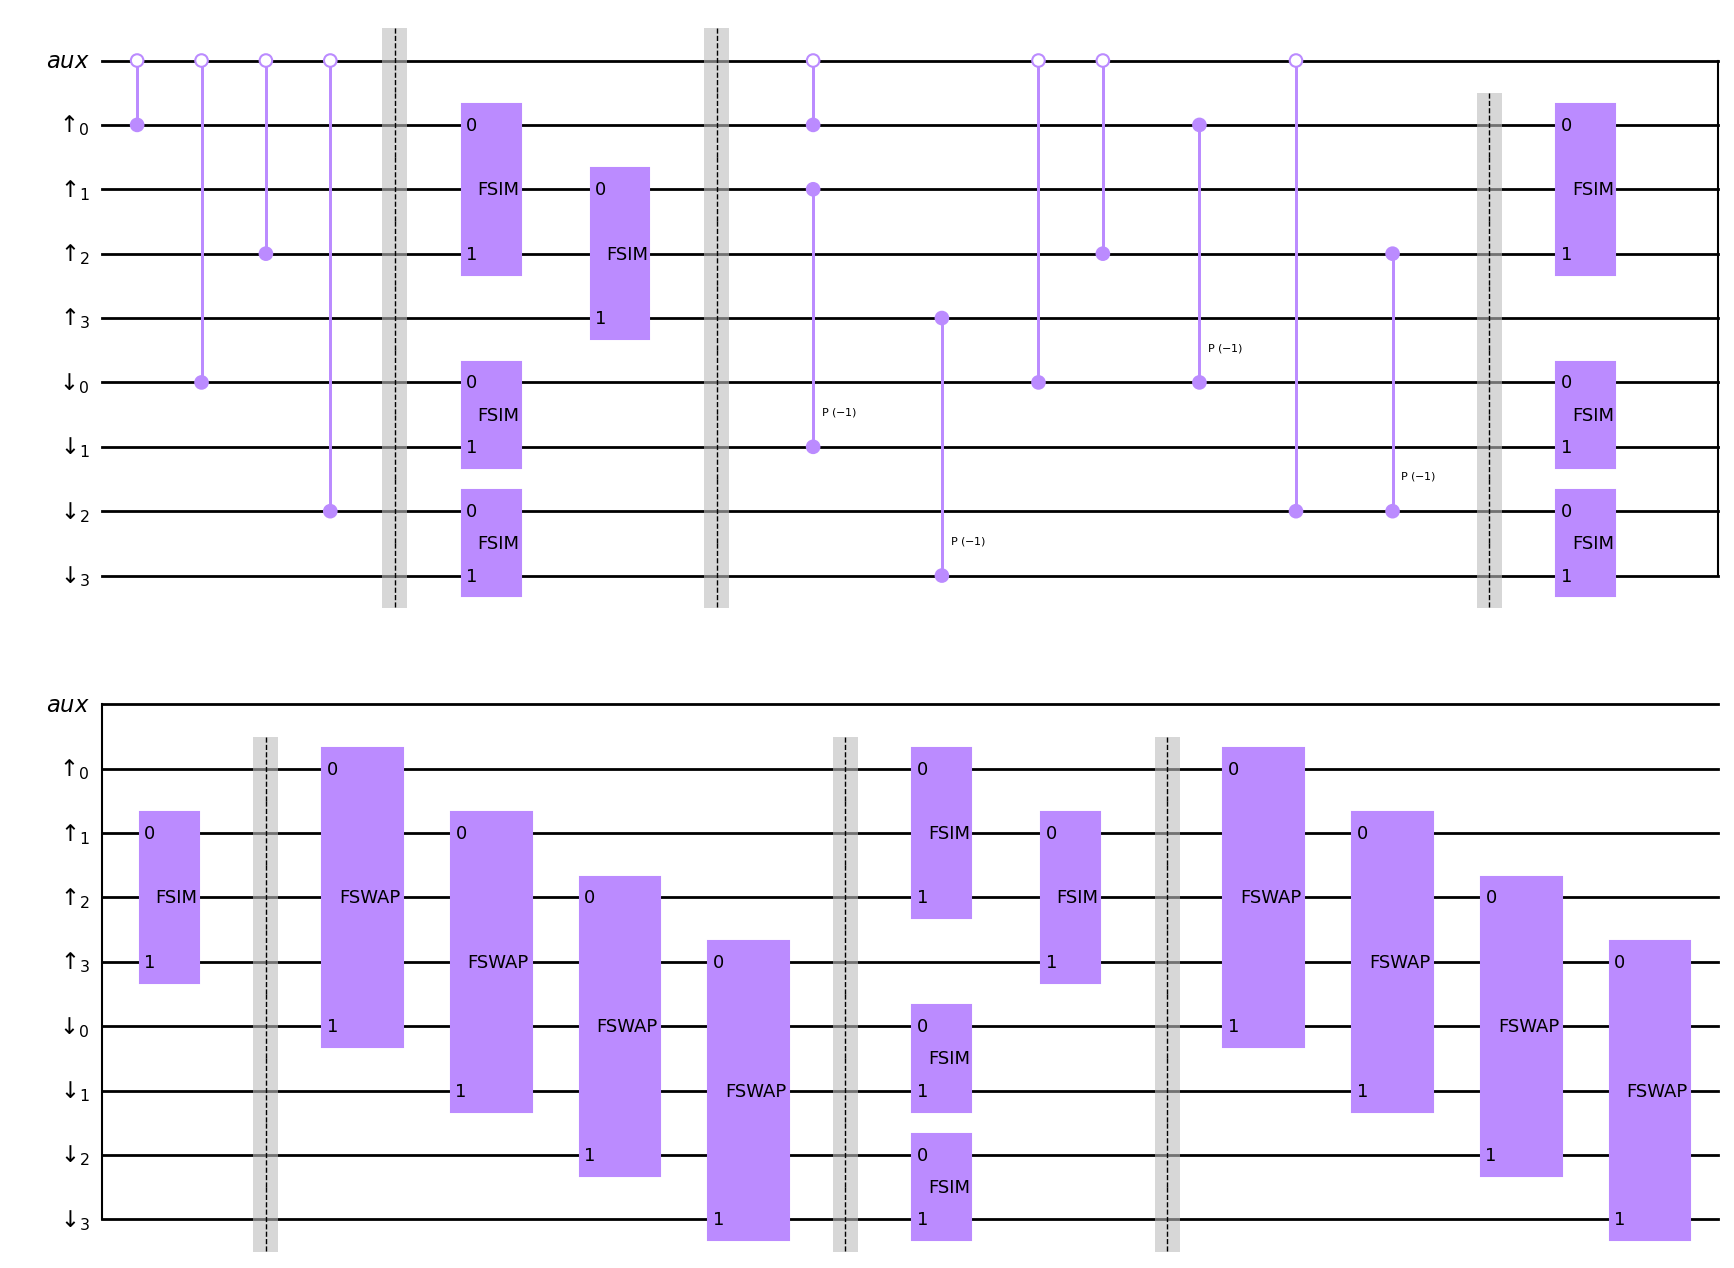

In [14]:
# onsite interaction
lam = -u*delta_t
for i in range(num_sites):
    qc_ctrl.cp(lam, spin_up[i], spin_down[i])


qc_ctrl.barrier(spin_up, spin_down)


theta = -2*t
beta = 0
hoppings = [(spin_up[0], spin_up[2]), (spin_up[1], spin_up[3]), (spin_down[0], spin_down[1]), (spin_down[2], spin_down[3])]
for hop in hoppings:
    #qc_ctrl.append(XXPlusYYGate(theta, beta), hop)
    gate1, gate2 = hop
    qc_ctrl.append(fSIM, [gate1, gate2])

qc_ctrl.barrier(spin_up, spin_down)

swaps = [(spin_up[0], spin_down[0]), (spin_up[1], spin_down[1]), (spin_up[2], spin_down[2]), (spin_up[3], spin_down[3])]
for swap in swaps:
    gate1, gate2 = swap
    #qc_ctrl.iswap(gate1, gate2)
    qc_ctrl.append(fSWAP, [gate1, gate2])


qc_ctrl.barrier(spin_up, spin_down)

theta = -2*t
beta = 0
hoppings = [(spin_up[0], spin_up[2]), (spin_up[1], spin_up[3]), (spin_down[0], spin_down[1]), (spin_down[2], spin_down[3])]
for hop in hoppings:
    #qc_ctrl.append(XXPlusYYGate(theta, beta), hop)
    gate1, gate2 = hop
    qc_ctrl.append(fSIM, [gate1, gate2])

qc_ctrl.barrier(spin_up, spin_down)

# swap back
swaps = [(spin_up[0], spin_down[0]), (spin_up[1], spin_down[1]), (spin_up[2], spin_down[2]), (spin_up[3], spin_down[3])]
for swap in swaps:
    gate1, gate2 = swap
    #qc_ctrl.iswap(gate1, gate2)
    qc_ctrl.append(fSWAP, [gate1, gate2])


qc_ctrl.draw("mpl")

### Control-free H2

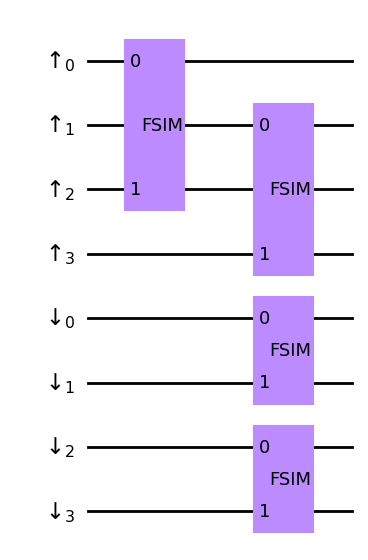

In [98]:
spin_up = QuantumRegister(num_sites, '↑')
spin_down = QuantumRegister(num_sites, '↓')
qc = QuantumCircuit(spin_up, spin_down)

theta = -2*t
beta = 0
hoppings = [(spin_up[0], spin_up[2]), (spin_up[1], spin_up[3]), (spin_down[0], spin_down[1]), (spin_down[2], spin_down[3])]
for hop in hoppings:
    gate1, gate2 = hop
    qc.append(fSIM, [gate1, gate2])

qc.draw("mpl")

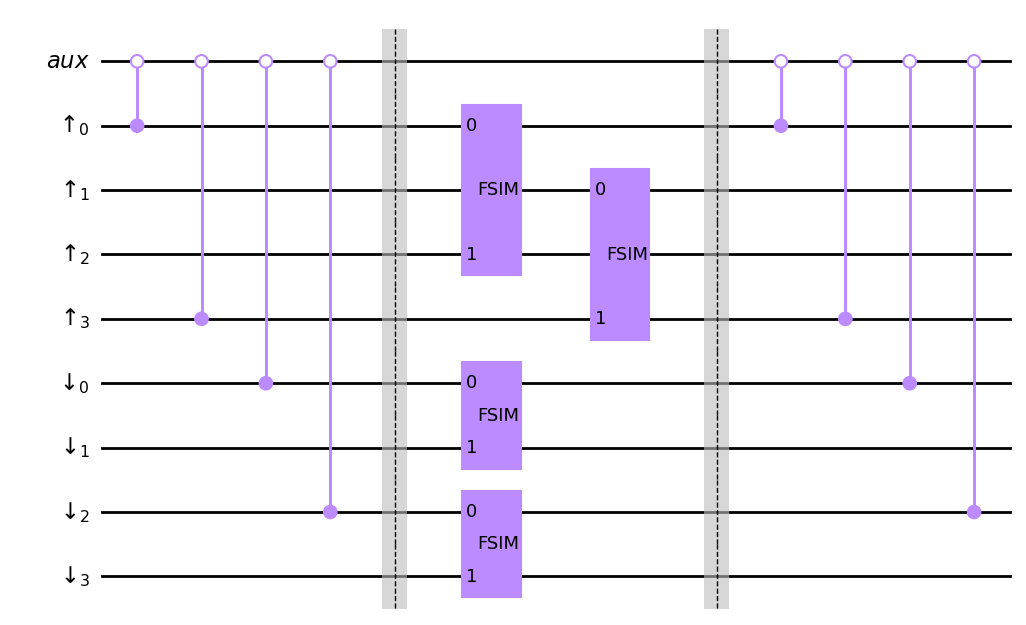

In [99]:
spin_up = QuantumRegister(num_sites, '↑')
spin_down = QuantumRegister(num_sites, '↓')
aux = QuantumRegister(1, "aux")
qc_ctrl = QuantumCircuit(aux, spin_up, spin_down)


qc_ctrl.cz(aux[0], spin_up[0], ctrl_state="0")
qc_ctrl.cz(aux[0], spin_up[3], ctrl_state="0")

qc_ctrl.cz(aux[0], spin_down[0], ctrl_state="0")
qc_ctrl.cz(aux[0], spin_down[2], ctrl_state="0")


qc_ctrl.barrier(aux, spin_up, spin_down)

theta = -2*t
beta = 0
hoppings = [(spin_up[0], spin_up[2]), (spin_up[1], spin_up[3]), (spin_down[0], spin_down[1]), (spin_down[2], spin_down[3])]
for hop in hoppings:
    gate1, gate2 = hop
    qc_ctrl.append(fSIM, [gate1, gate2])


qc_ctrl.barrier(aux, spin_up, spin_down)

qc_ctrl.cz(aux[0], spin_up[0], ctrl_state="0")
qc_ctrl.cz(aux[0], spin_up[3], ctrl_state="0")

qc_ctrl.cz(aux[0], spin_down[0], ctrl_state="0")
qc_ctrl.cz(aux[0], spin_down[2], ctrl_state="0")


qc_ctrl.draw("mpl")

In [100]:
import scipy.linalg

qc_matrix = circuit2matrix(qc, keep_qiskit_ordering=False)
qc_ref = scipy.linalg.block_diag(qc_matrix.conjugate().transpose(), qc_matrix)

qc_ctrl_matrix = circuit2matrix(qc_ctrl, keep_qiskit_ordering=False)

In [101]:
array_to_latex(qc_ref)

<IPython.core.display.Latex object>

In [102]:
array_to_latex(qc_ctrl_matrix)

<IPython.core.display.Latex object>

In [103]:
print("Error: " + str(np.linalg.norm(qc_ref - qc_ctrl_matrix, 2)))

Error: 0.0


### Control-free H1

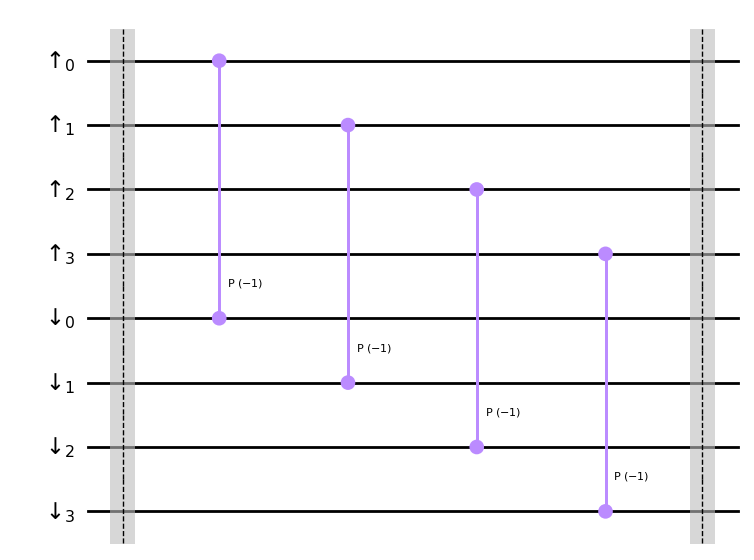

In [236]:
spin_up = QuantumRegister(num_sites, '↑')
spin_down = QuantumRegister(num_sites, '↓')
qc = QuantumCircuit(spin_up, spin_down)


qc.barrier(spin_up, spin_down)

# onsite interaction
lam = -u*delta_t
for i in range(num_sites):
    qc.cp(lam, spin_up[i], spin_down[i])


qc.barrier(spin_up, spin_down)

qc.draw("mpl")

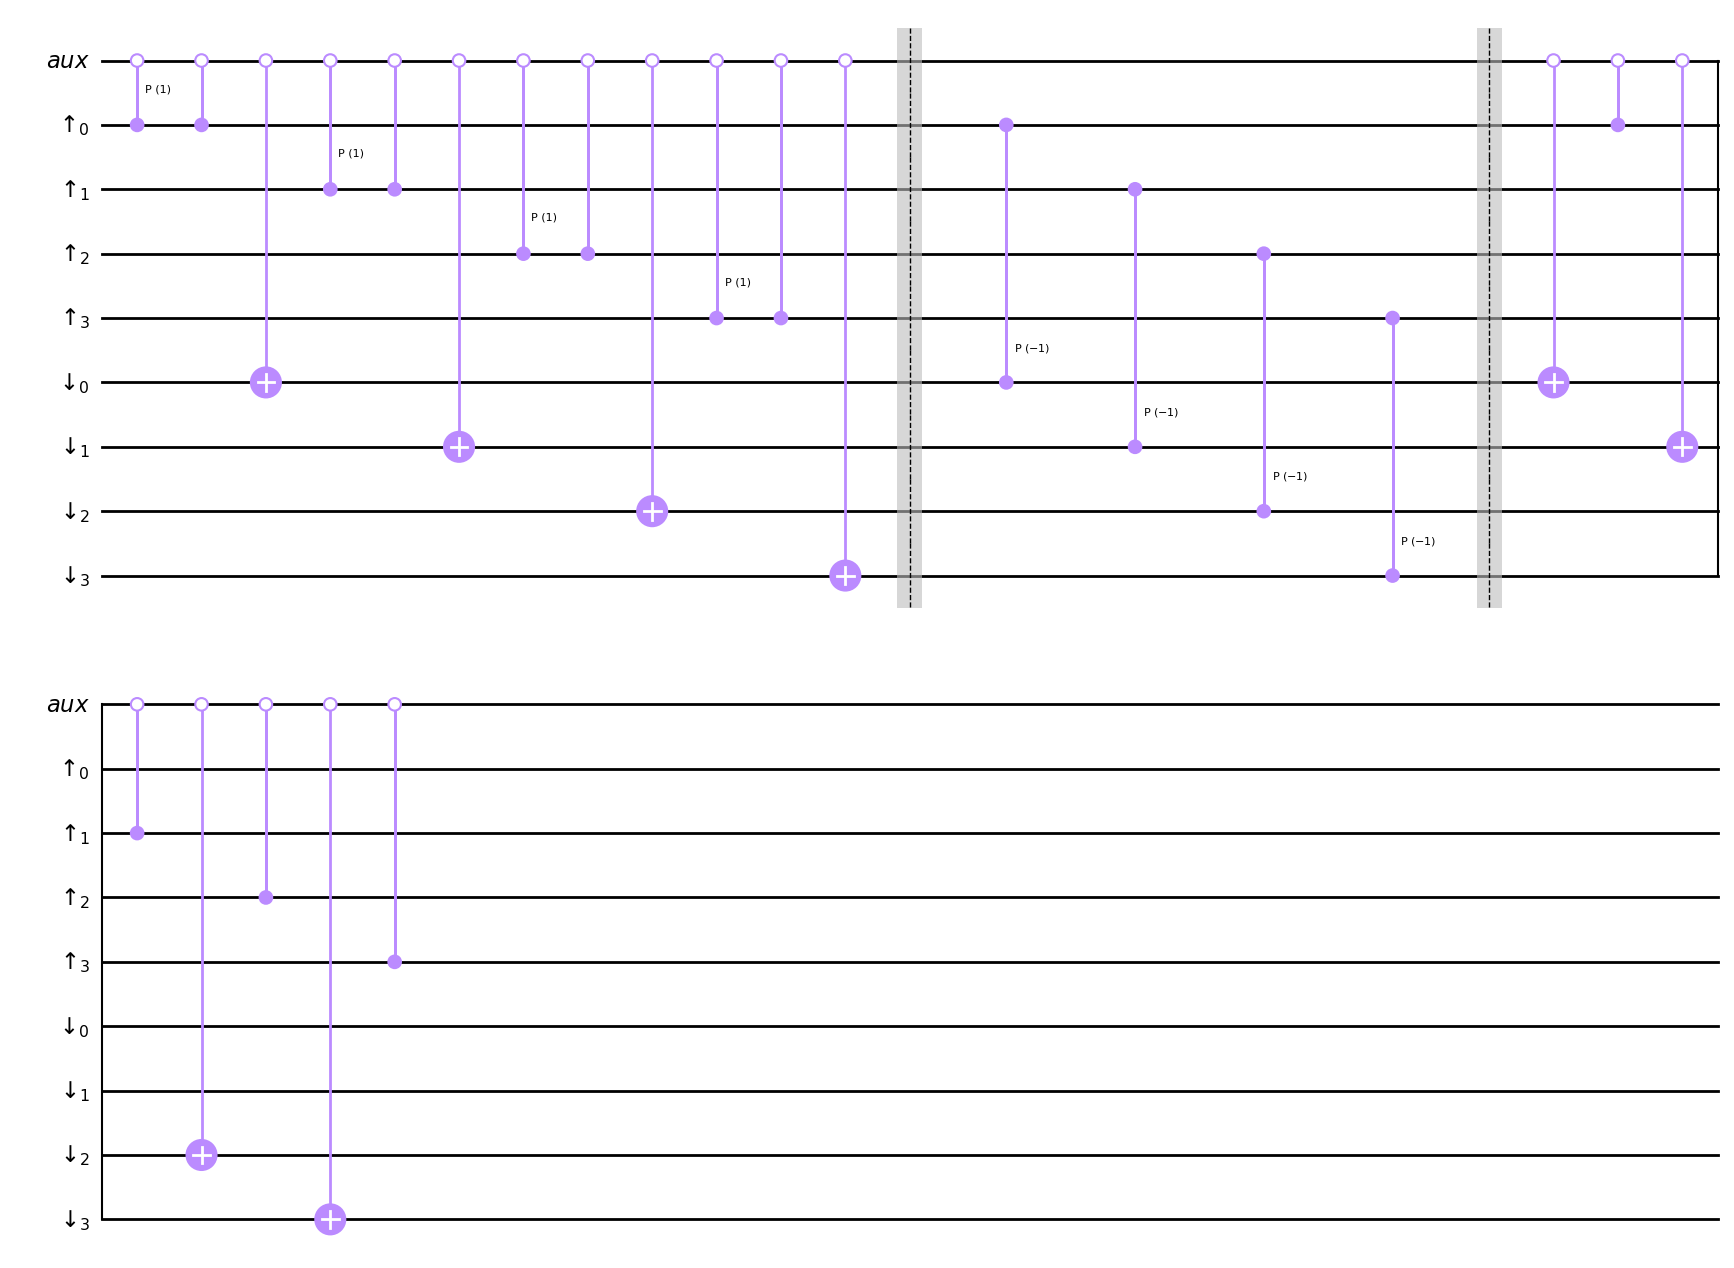

In [237]:
spin_up = QuantumRegister(num_sites, '↑')
spin_down = QuantumRegister(num_sites, '↓')
aux = QuantumRegister(1, "aux")
qc_ctrl = QuantumCircuit(aux, spin_up, spin_down)


for i in range(num_sites):
    qc_ctrl.cp(-lam, aux[0], spin_up[i], ctrl_state="0")
    qc_ctrl.cz(aux[0], spin_up[i], ctrl_state="0")
    qc_ctrl.cx(aux[0], spin_down[i], ctrl_state="0")


qc_ctrl.barrier(aux, spin_up, spin_down)

# onsite interaction
lam = -u*delta_t
for i in range(num_sites):
    qc_ctrl.cp(lam, spin_up[i], spin_down[i])


qc_ctrl.barrier(aux, spin_up, spin_down)

for i in range(num_sites):
    qc_ctrl.cx(aux[0], spin_down[i], ctrl_state="0")
    qc_ctrl.cz(aux[0], spin_up[i], ctrl_state="0")

qc_ctrl.draw("mpl")

In [238]:
import scipy.linalg

qc_matrix = circuit2matrix(qc, keep_qiskit_ordering=False)
qc_ref = scipy.linalg.block_diag(qc_matrix.conjugate().transpose(), qc_matrix)

qc_ctrl_matrix = circuit2matrix(qc_ctrl, keep_qiskit_ordering=False)

In [239]:
array_to_latex(qc_ref)

<IPython.core.display.Latex object>

In [240]:
array_to_latex(qc_ctrl_matrix)

<IPython.core.display.Latex object>

In [241]:
print("Error: " + str(np.linalg.norm(qc_ref - qc_ctrl_matrix, 2)))

Error: 4.47545209131181e-16
